---
<h1 style="text-align: center;">
CSCI 4521: Applied Machine Learning (Fall 2024)
</h1>

<h1 style="text-align: center;">
Homework 2
</h1>

<h3 style="text-align: center;">
(Due Thu, Oct. 3, 11:59 PM CT)
</h3>

---

### Let's consider the breast cancer dataset `breast_cancer_csci4521_hw2.csv`. This dataset is similar to (but not exactly the same as) the one you used for homework 1. Each row is a sample and column is a feature (or label). Each sample has a patient ID (first column) and diagnosis/label (second column) with values "M" for malignant and "B" for benign. Write **PySpark** (and Python) code to answer each of the following questions (you cannot use Pandas). For any question which asks you to modify the dataset, make sure to use the modified dataset for all subsequent questions.

In [25]:
!pip install pyspark
from pyspark.sql import DataFrame
from pyspark.sql.functions import mean as mean, stddev as stddev, median as median
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.ml.feature import MinMaxScaler
import matplotlib.pyplot as plt
from pyspark.sql.types import ArrayType, DoubleType

#### 0. **(2 points)** Load the dataset and print the top 10 rows and the number of samples and features. Note, this dataset includes a header (the first line in the csv file).

In [26]:
spark = SparkSession.builder.appName("PySpark_Tutorial").getOrCreate()
df=spark.read.csv('/content/breast_cancer_csci4521_hw2.csv',header=True)

df.show(n=10)
col=len(df.columns)
rows=df.count()
print(rows,col-1)

+----------+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|patient_id|diagnosis|mean_radius|mean_texture|mean_perimeter|mean_area|mean_smoothness|mean_compactness|mean_concavity|mean_concave_points|mean_symmetry|mean_fractal_dimension|se_radius|se_texture|se_perimeter|se_area|se_smoothness|se_compactness|se_concavity|se_concave_points|se_symmetry|se_fractal_dimension|worst_radius|worst_texture|worst_perimeter|worst_area|worst_smoothness|worst_compactness|worst_concavity|worst_concave_points|worst_symmetry|worst_fractal_dimension|
+----------+---------+-----------+----------

#### 1. **(10 points)** What are the means, standard deviations, minimum, and maximum values of each of the features?

In [27]:
col_array=df.columns[2:]
for col in col_array:
     df= df.withColumn(col, F.col(col).cast('float'))
df[col_array[2:]].describe().filter(F.col("summary")!="count").show()

+-------+------------------+------------------+--------------------+--------------------+-------------------+-------------------+--------------------+----------------------+-------------------+------------------+------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+------------------+------------------+-----------------+-------------------+-------------------+------------------+--------------------+--------------------+-----------------------+
|summary|    mean_perimeter|         mean_area|     mean_smoothness|    mean_compactness|     mean_concavity|mean_concave_points|       mean_symmetry|mean_fractal_dimension|          se_radius|        se_texture|      se_perimeter|          se_area|       se_smoothness|      se_compactness|        se_concavity|   se_concave_points|         se_symmetry|se_fractal_dimension|     worst_radius|     worst_texture|   worst_peri

#### 2. **(15 points)** Choose any method to replace all missing values and print the top 10 rows of the dataframe before and after the replacement. Explain what method you used and why.

In [28]:
cols_to_replace_missing_vals=df.columns[2:]
print("data before replacement")
df.show(n=10)
#Q2
#replace missing value with mean by calculating mean and using fillna method because missing values is represent with null.
# I chose the mean value to replace as the overall data has less variance and lesser the variance the more the mean is a representative of the data
# As such replacing missing values with the data mean makes sense as mean can aproximately substitute for actual data points.
for col in cols_to_replace_missing_vals:
  Mean=df.select(mean(col)).collect()[0][0]
  df = df.fillna(Mean, subset=col)
print("data after replacement")
df.show(n=10)

data before replacement
+----------+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|patient_id|diagnosis|mean_radius|mean_texture|mean_perimeter|mean_area|mean_smoothness|mean_compactness|mean_concavity|mean_concave_points|mean_symmetry|mean_fractal_dimension|se_radius|se_texture|se_perimeter|se_area|se_smoothness|se_compactness|se_concavity|se_concave_points|se_symmetry|se_fractal_dimension|worst_radius|worst_texture|worst_perimeter|worst_area|worst_smoothness|worst_compactness|worst_concavity|worst_concave_points|worst_symmetry|worst_fractal_dimension|
+----------+--------

#### 3. **(25 points)** Choose any method to normalize or standardize the features and print the top 10 rows before and after. Explain what method you used and why. After the transformation, plot a histogram of values for feature "mean_symmetry".

data before scaling
+----------+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+---------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|patient_id|diagnosis|mean_radius|mean_texture|mean_perimeter|mean_area|mean_smoothness|mean_compactness|mean_concavity|mean_concave_points|mean_symmetry|mean_fractal_dimension|se_radius|se_texture|se_perimeter|  se_area|se_smoothness|se_compactness|se_concavity|se_concave_points|se_symmetry|se_fractal_dimension|worst_radius|worst_texture|worst_perimeter|worst_area|worst_smoothness|worst_compactness|worst_concavity|worst_concave_points|worst_symmetry|worst_fractal_dimension|
+----------+--------

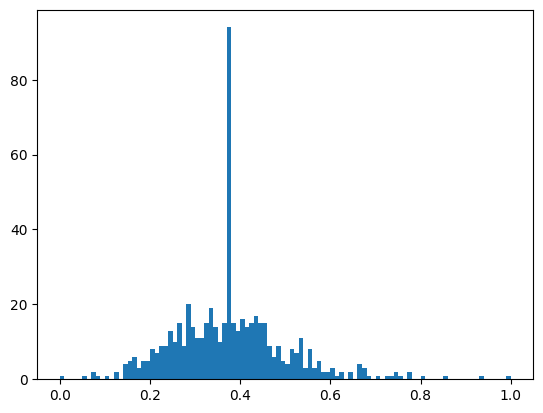

In [29]:
from pyspark.ml.functions import vector_to_array
cols = df.columns
#Question 3 Used min max scalar normalize the data between zero and one.
#Normalize the data as some feature like se_area have very large ranges for their minimum and maximum values compared to other data
# As a result normalize the data so they are not represented dispropotionally
def split_arr_to_list(col):
    def to_list(v):
        return v.toArray().tolist()
    return F.udf(to_list, ArrayType(DoubleType()))(col)



vec_assembler = VectorAssembler(inputCols=cols[2:], outputCol="vec_feats")
df_used= vec_assembler.transform(df)
print("data before scaling")
print( df.show(n=10))
scaler = MinMaxScaler(inputCol = "vec_feats", outputCol = "scaled_features")

scaler_model = scaler.fit(df_used)
df_used= scaler_model.transform(df_used)
df3 = df_used.withColumn("split_int", split_arr_to_list(F.col("scaled_features"))).select("patient_id","diagnosis","vec_feats","scaled_features",*[F.col("split_int")[i] for i in range(30)])

StringArr=[]
for i in range(2,len(df_used.columns)-2):

  df3=df3.withColumnRenamed("split_int"+"["+str(i-2)+"]",df_used.columns[i])# renaming columns




print("Data after scaling:")
df=df3
df.show(n=10)
print("The graph of mean_symmetry")

plt.hist(df.select(F.collect_list('mean_symmetry')).first()[0], bins = 100)
plt.show()

#### 4. **(3 points)** Identify if there are duplicate samples (print their patient IDs) and remove them.


In [30]:
#answer to Q4

df.exceptAll(df.dropDuplicates()).select("patient_id").show()
df=df.drop_duplicates()



+----------+
|patient_id|
+----------+
|   8710441|
+----------+



#### 5. **(15 points)** Choose any method to remove outliers. Print the number of samples before and after removing outliers as well as the patient IDs of the outliers removed.


In [31]:
cols=df.columns[4:34]
# Question 5 use standard deviation method to remove any data points lower than or greater the 3 standiviation from mean
print("Shape of a data before removing outliers")
print(("num_samples:",df.count()))
print("\n")
total_outlier=0
outliers_collector=[]
upper_list=[]
lower_list=[]

for j in cols:
  data_mean = df.select(F.mean(F.col(j)).alias('mean')).collect()[0]['mean']
  data_std = df.select(F.stddev(F.col(j)).alias('std')).collect()[0]['std']
  cut_off = data_std * 3
  lower, upper = data_mean - cut_off, data_mean + cut_off
  lower_list.append(lower)
  upper_list.append(upper)

for i in range(0,len(cols)):
  outliers_df = df.where((F.col(cols[i]) < lower_list[i]) | (F.col(cols[i]) > upper_list[i]))
  outliers_collector.append(outliers_df)
  df = df.where((F.col(cols[i]) >= lower_list[i]) & (F.col(cols[i]) <= upper_list[i]))



  total_outlier+=outliers_df.count()
print("Shape of a data after removing outliers")
print(("num_samples:",df.count()))


print("Num of outliers:",total_outlier)
for i in range(0,len(outliers_collector)):
  if outliers_collector[i].count()!=0:
    outliers_collector[i].select(outliers_collector[i].columns[0]).show()


Shape of a data before removing outliers
('num_samples:', 568)


Shape of a data after removing outliers
('num_samples:', 494)
Num of outliers: 74
+----------+
|patient_id|
+----------+
|    899987|
| 911296202|
|    873592|
|   8611555|
|   8810703|
+----------+

+----------+
|patient_id|
+----------+
|  88119002|
|  88330202|
|  88725602|
|  88203002|
+----------+

+----------+
|patient_id|
+----------+
|  91762702|
|    865423|
+----------+

+----------+
|patient_id|
+----------+
|    915143|
|    878796|
+----------+

+----------+
|patient_id|
+----------+
|    915186|
|  84348301|
|    863030|
|     92751|
+----------+

+----------+
|patient_id|
+----------+
|    887181|
|    842302|
|    873593|
|   8610862|
|    927241|
|     86355|
+----------+

+----------+
|patient_id|
+----------+
|   8710441|
+----------+

+----------+
|patient_id|
+----------+
|   8913049|
|    852631|
|    858970|
+----------+

+----------+
|patient_id|
+----------+
|    859711|
|    901315|
|    894329|


#### 6. **(25 points)** Choose any method to select the most important features and print the name of which features those are. Explain what method you used and why.

In [32]:
#Q6 The method used select the variables was the anova test top seven important columns
# Used method as method can be used to figure out the importance of continuos data on the catagorical data in our data set
#Cannot use chi square test as Chi square test is gennerally used for catorigical data and not continous data
from pyspark.ml.feature import UnivariateFeatureSelector


indexer = StringIndexer(inputCols=['diagnosis'], outputCols=['diagnosis_t'])

df_enc = indexer.fit(df).transform(df)
cols=df_enc.columns[2:]
selector = UnivariateFeatureSelector(featuresCol = "scaled_features", outputCol="selected_features", labelCol = "diagnosis_t")
selector.setFeatureType("continuous").setLabelType("categorical").setSelectionThreshold(7)
model = selector.fit(df_enc[cols])
df_feat_sel = model.transform(df)
col_name=[]
columns_selected=[]
columns_selected.append(df_enc["patient_id"])
print(f"Features selected starting from mean radius: {model.selectedFeatures}")


for i in model.selectedFeatures:
  col_name.append(cols[i+2])
  columns_selected.append(df_enc[cols[i+2]])
print(col_name)
final_df=df_enc[columns_selected]
#columns_selected.show(n=1)

Features selected starting from mean radius: [0, 1, 2, 3, 5, 6, 7]
['mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area', 'mean_compactness', 'mean_concavity', 'mean_concave_points']


#### 7. **(5 points)** After all the above, how many samples and features (including patient ID) does the final dataset have?

In [33]:
print("Shape of data")
print("columns: ",len(final_df.columns)," rows:",final_df.count())




Shape of data
columns:  8  rows: 494


---